In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import backend
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

In [2]:
# Prepare GPU
def prep_devices():
    phy_gpus = tf.config.list_physical_devices(device_type='GPU')
    
    for gpu in phy_gpus:
        tf.config.experimental.set_memory_growth(device=gpu, enable=True)

    log_gpus = tf.config.list_logical_devices(device_type='GPU')
    phy_cpus = tf.config.list_physical_devices(device_type='CPU')
    log_cpus = tf.config.list_logical_devices(device_type='CPU')

    print("Physical GPUs: {}\tLogical GPUs: {}\nPhysical CPUs: {}\tLogical CPUs: {}".format(len(phy_gpus),
                                                                                             len(log_gpus),
                                                                                             len(phy_cpus),
                                                                                             len(log_cpus)))

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
prep_devices()

Physical GPUs: 1	Logical GPUs: 1
Physical CPUs: 1	Logical CPUs: 1


In [4]:
x = np.linspace(0, 50, 501)

In [5]:
y = np.sin(x)

<AxesSubplot:>

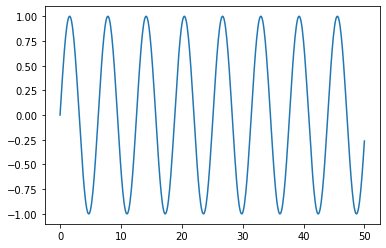

In [6]:
sns.lineplot(x=x, y=y)

In [7]:
df = pd.DataFrame(data=y, index=x, columns=['Sine'])

In [8]:
df

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


In [9]:
test_percent = 0.1

In [10]:
len(df) * test_percent

50.1

In [11]:
test_point = np.round(len(df) * test_percent)

In [12]:
test_index = int(len(df) - test_point)

In [13]:
test_index

451

In [14]:
train = df.iloc[:test_index]

In [15]:
test = df.iloc[test_index:]

In [16]:
scaler = MinMaxScaler()

In [17]:
scaler.fit(train)

MinMaxScaler()

In [18]:
scaled_train = scaler.transform(train)

In [19]:
sclaed_test = scaler.transform(test)

In [20]:
length = 50
batch_size = 1

In [21]:
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [22]:
len(scaled_train)

451

In [23]:
len(generator)

401

In [24]:
x_gen, y_gen = generator[0]

In [25]:
x_gen

array([[[4.99999116e-01],
        [5.49916225e-01],
        [5.99334579e-01],
        [6.47760405e-01],
        [6.94709850e-01],
        [7.39713809e-01],
        [7.82322618e-01],
        [8.22110545e-01],
        [8.58680040e-01],
        [8.91665714e-01],
        [9.20737985e-01],
        [9.45606372e-01],
        [9.66022399e-01],
        [9.81782075e-01],
        [9.92727935e-01],
        [9.98750612e-01],
        [9.99789928e-01],
        [9.95835500e-01],
        [9.86926839e-01],
        [9.73152957e-01],
        [9.54651478e-01],
        [9.31607263e-01],
        [9.04250562e-01],
        [8.72854714e-01],
        [8.37733417e-01],
        [7.99237589e-01],
        [7.57751870e-01],
        [7.13690771e-01],
        [6.67494535e-01],
        [6.19624741e-01],
        [5.70559686e-01],
        [5.20789614e-01],
        [4.70811810e-01],
        [4.21125636e-01],
        [3.72227539e-01],
        [3.24606094e-01],
        [2.78737119e-01],
        [2.35078919e-01],
        [1.9

In [49]:
y_gen

array([[0.02053313]])

In [51]:
n_features = 1

In [52]:
# Define model
# Build model
def model_func(clear_session=True):
    if clear_session:
        backend.clear_session()
            
    model = Sequential()
    
    model.add(SimpleRNN(50, input_shape=(length, n_features)))
    model.add(Dense(1))
    
    model.summary()
    
    return model

In [64]:
# Fit model
model = model_func()
model.compile(loss='mse', optimizer='adam')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                2600      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.fit(generator, epochs=5)

Epoch 1/5
401/401 [==============================] - 8s 21ms/step - loss: 0.0207
Epoch 2/5
401/401 [==============================] - 8s 21ms/step - loss: 2.3116e-04
Epoch 3/5
401/401 [==============================] - 8s 21ms/step - loss: 1.2956e-04
Epoch 4/5
401/401 [==============================] - 8s 21ms/step - loss: 1.1396e-04
Epoch 5/5
401/401 [==============================] - 8s 21ms/step - loss: 7.4186e-04


<AxesSubplot:>

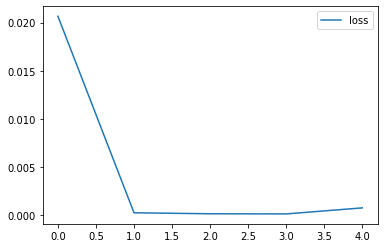

In [66]:
losses = pd.DataFrame(model.history.history)
sns.lineplot(data=losses)

In [68]:
# Create moving window of evaluation batches
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape(1, length, n_features)

for index in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [69]:
true_predictions = scaler.inverse_transform(test_predictions)

In [70]:
test['Predictions'] = true_predictions

/tmp/ipykernel_4778/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:>

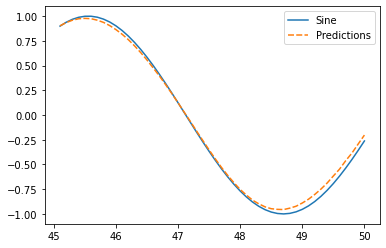

In [72]:
sns.lineplot(data=test)